### Data format

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import os

%matplotlib inline

In [21]:
base_path = './DataScience2019_MRI/'

behaviour_path = 'Behavioral/cleaned'
behaviour_file = 'HBNFinalSummaries.csv'

In [22]:
behaviour_data = pd.read_csv(os.path.join(base_path, behaviour_path, behaviour_file), low_memory=False)
whole_data = behaviour_data

In [23]:
print(behaviour_data.shape)

(2096, 399)


A total of 2096 subjects are provided with a total of 399 feature columns. From those around 150 features regard the diagnosis given (15 for each of the 10 diagnosis).

We now filter out subjects that have no diagnosis given (incomplete evaluation)

In [24]:
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
behaviour_data = behaviour_data.reset_index(drop=True)

In [25]:
behaviour_data['DX_01_Cat'].value_counts()

Neurodevelopmental Disorders                                  1167
No Diagnosis Given                                             235
Anxiety Disorders                                              189
Depressive Disorders                                            94
Disruptive                                                      40
Trauma and Stressor Related Disorders                           35
Obsessive Compulsive and Related Disorders                      16
Elimination Disorders                                           11
Other Conditions That May Be a Focus of Clinical Attention       8
Bipolar and Related Disorders                                    6
Disruptive, Impulse Control and Conduct Disorders                5
Neurocognitive Disorders                                         3
Schizophrenia Spectrum and other Psychotic Disorders             3
Substance Related and Addictive Disorders                        1
Gender Dysphoria                                              

We could also get rid of disorder categories that can be found less than a $threshold$ amount of times. We perform this taking into acount all possible diagnosis for each subject and not only the first one (DX_01_Cat).

In [26]:
threshold = 10

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]

disorders_all = behaviour_data[category_columns].values.flatten()
disorders_all = disorders_all[np.array(disorders_all, dtype=np.str) != 'nan']

unique, counts = np.unique(disorders_all, return_counts=True)

most_common_disorders = []
for un, c in zip(unique, counts):
    if c >= threshold:
        most_common_disorders.append(un)
        print('{0: <60} found {1} times'.format(un, c))

Anxiety Disorders                                            found 596 times
Bipolar and Related Disorders                                found 10 times
Depressive Disorders                                         found 179 times
Disruptive                                                   found 240 times
Disruptive, Impulse Control and Conduct Disorders            found 35 times
Elimination Disorders                                        found 96 times
Feeding and Eating Disorders                                 found 10 times
Neurodevelopmental Disorders                                 found 2081 times
No Diagnosis Given                                           found 235 times
Obsessive Compulsive and Related Disorders                   found 74 times
Other Conditions That May Be a Focus of Clinical Attention   found 23 times
Schizophrenia Spectrum and other Psychotic Disorders         found 10 times
Trauma and Stressor Related Disorders                        found 77 times


In [27]:
most_common_disorders.remove('No Diagnosis Given')

We now create for each individual features concerning these diagnosis disregarding all other information about the diagnosis

In [28]:
classes = np.zeros((len(most_common_disorders), behaviour_data.shape[0]), dtype=np.int32)
df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = df_disorders[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)

Now we can safelly remove previous diagnoses

In [29]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX')!=-1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [30]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

In [31]:
behaviour_data.shape

(1814, 260)

Now we can continue to remove columns that have a high percentage of Nan

In [32]:
threshold = 0.2

columns_mask = pd.isnull(behaviour_data).sum() / behaviour_data.shape[0] > threshold

print('Droping this many columns:', np.sum(columns_mask))

behaviour_data = behaviour_data.drop(columns=behaviour_data.columns[columns_mask])

Droping this many columns: 181


In [33]:
behaviour_data.columns

Index(['Anonymized.ID', 'EID', 'Sex', 'Age', 'Study.Site', 'APQ_P_OPD',
       'APQ_P_Total', 'APQ_SR_OPD', 'APQ_SR_Total', 'ARI_P_Total_Score',
       'ARI_S_Total_Score', 'ASSQ_Total', 'Barratt_Total_Edu',
       'Barratt_Total_Occ', 'Barratt_Total', 'CBCL_AD', 'CBCL_WD', 'CBCL_SC',
       'CBCL_RBB', 'CBCL_AB', 'CBCL_Int', 'CBCL_Ext', 'CBCL_C', 'CBCL_Total',
       'CELF_Total', 'CTOPP_EL_R', 'CTOPP_BW_R', 'CTOPP_NR_R', 'CTOPP_RD_R',
       'CTOPP_RL_R', 'CTOPP_RSN_Comp', 'DTS_absorption', 'DTS_appraisal',
       'DTS_regulation', 'DTS_tolerance', 'DTS_total', 'EHQ_Total',
       'ICU_P_Callous', 'ICU_P_Uncaring', 'ICU_P_Unemotional', 'ICU_P_Total',
       'NLES_P_TotalEvents', 'NLES_P_Upset_Total', 'PCIAT_Total', 'mdx',
       'SCARED_P_GD', 'SCARED_P_PN', 'SCARED_P_SC', 'SCARED_P_SH',
       'SCARED_P_SP', 'SCARED_P_Total', 'SCQ_Total', 'SRS_AWR', 'SRS_COG',
       'SRS_COM', 'SRS_DSMRRB', 'SRS_MOT', 'SRS_RRB', 'SRS_SCI', 'SRS_Total',
       'WIAT_Num_Raw', 'WIAT_Pseudo_Raw', 'WIA

Statistics

An important factor is the distribution of age in the dataset, as a different age allows different questionnaires to be filled.

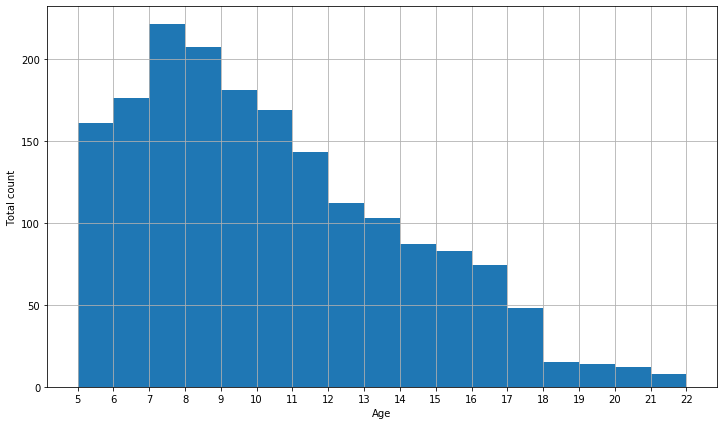

In [34]:
bins = list(range(math.floor(behaviour_data['Age'].min()), math.ceil(behaviour_data['Age'].max() + 1)))

fig = plt.gcf()
fig.set_size_inches(12, 7)
ax = behaviour_data['Age'].hist(bins = bins)
ax.set_xticks(bins)
ax.set_xlabel('Age')
ax.set_ylabel('Total count')

plt.show()

- A recommended streategy would be to use only specific ages (for instance ages 8-16)
- We could also create age bins as a new feature instead of age categories
- Age in every case plays a significant role for the interpretation of the tests and the final results

Display the largest correlation between disorders

In [35]:
correlation = behaviour_data[most_common_disorders] \
    .apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

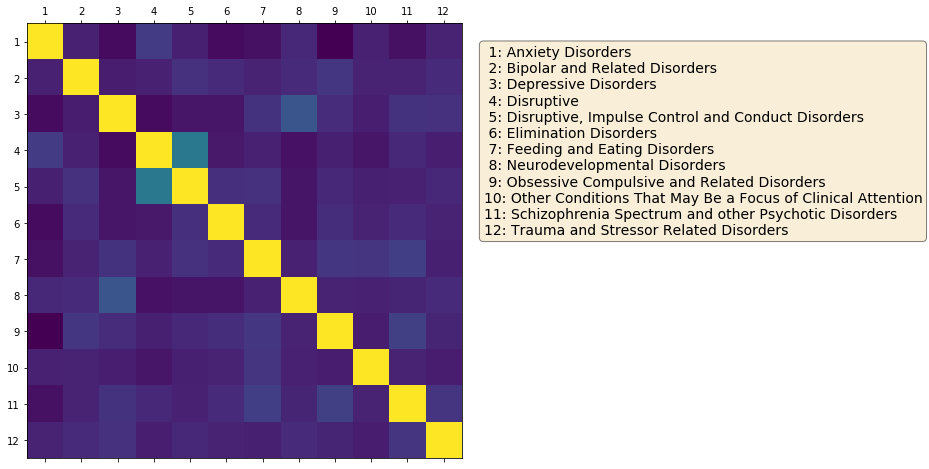

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

ax.matshow(correlation.values)
ax.set_xticks([i for i in range(0, len(most_common_disorders))])
ax.set_yticks([i for i in range(len(most_common_disorders) - 1, -1, -1)])
ax.set_xticklabels([str(i) for i in range(1, len(most_common_disorders) + 1)])
ax.set_yticklabels([str(i) for i in range(len(most_common_disorders), 0, -1)])
ax.set_xlim([-0.5, 11.5])
ax.set_ylim([11.5, -0.5])

texts = []
for i, disorder in enumerate(most_common_disorders):
    texts.append(r'%2d: %s' % (i + 1, disorder))

textstr = '\n'.join(texts)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(1.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.show()

In [37]:
display_largest = 8

# get rid of the diagonal elements and avoid displaying the same pairs twice
correlation.stack().nlargest(len(most_common_disorders) + display_largest * 2)[len(most_common_disorders)::2]

Disruptive                                  Disruptive, Impulse Control and Conduct Disorders             0.331817
Depressive Disorders                        Neurodevelopmental Disorders                                  0.179897
Obsessive Compulsive and Related Disorders  Schizophrenia Spectrum and other Psychotic Disorders          0.099270
Feeding and Eating Disorders                Schizophrenia Spectrum and other Psychotic Disorders          0.095011
Anxiety Disorders                           Disruptive                                                    0.082366
Feeding and Eating Disorders                Obsessive Compulsive and Related Disorders                    0.061134
Bipolar and Related Disorders               Obsessive Compulsive and Related Disorders                    0.061134
Feeding and Eating Disorders                Other Conditions That May Be a Focus of Clinical Attention    0.059771
dtype: float64

At the final stage we will also need to filter subjects based on those that have an MRI available!

For the above we did not consider the order of the diagnosis. A more elaborate review should also take this into account. Now we display how secondary diagnoses are distributed based on the first.

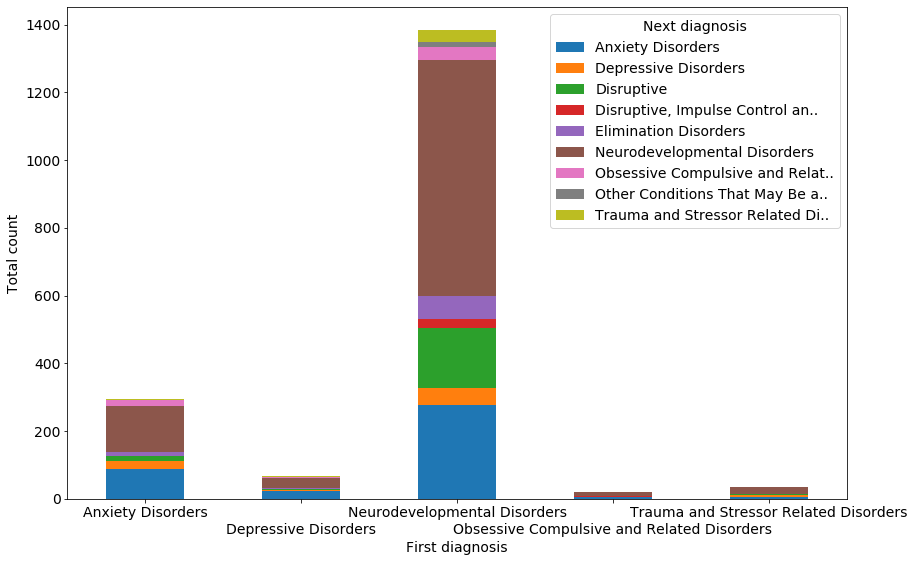

In [89]:
# most common further diagnosis based on the first diagnosis (by category)

first_categories = np.array(whole_data['DX_01_Cat'].values, dtype=np.str)

for i in range(2, 11):
    next_categories = np.array(whole_data['DX_' + str(i).zfill(2) + '_Cat'].values, dtype=np.str)

    if i == 2:
        first_categories_total = first_categories
        next_categories_total = next_categories
    else:
        first_categories_total = np.concatenate((first_categories_total, first_categories))
        next_categories_total = np.concatenate((next_categories_total, next_categories))
        
threshold = 10

# remove nans
mask = ~(first_categories_total == 'nan')
first_categories_total = first_categories_total[mask]
next_categories_total = next_categories_total[mask]

mask = ~(next_categories_total == 'nan')
first_categories_total = first_categories_total[mask]
next_categories_total = next_categories_total[mask]

# unique categories with less than threshold apearrences
unique, counts = np.unique(first_categories_total, return_counts=True)
valid_categories = unique[counts > threshold]

mask = [x in valid_categories for x in first_categories_total]
first_categories_total = first_categories_total[mask]
next_categories_total = next_categories_total[mask]

# same for secondary diagnoses
unique, counts = np.unique(next_categories_total, return_counts=True)
valid_categories = unique[counts > threshold]

mask = [x in valid_categories for x in next_categories_total]
first_categories_total = first_categories_total[mask]
next_categories_total = next_categories_total[mask]

truncate_length = 30
next_categories_total = [(data[:truncate_length] + '..') if len(data) > truncate_length
                         else data for data in next_categories_total]

rcParams['figure.figsize'] = 13, 8
rcParams['font.size'] = 14


df = pd.DataFrame({'first_diagnosis': first_categories_total, 'next_diagnosis': next_categories_total})
ct = pd.crosstab(df.first_diagnosis, df.next_diagnosis)

ax = ct.plot.bar(stacked=True)

plt.legend(title='Next diagnosis')
plt.xlabel('First diagnosis')
plt.ylabel('Total count')
plt.xticks(rotation=0)

labels = ax.set_xticklabels(np.unique(first_categories_total))
for i, label in enumerate(labels):
    label.set_y(label.get_position()[1] - (i % 2) * 0.035)

plt.tight_layout()
plt.show()

### Simple classifier

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import UndefinedMetricWarning


for check_disorder in most_common_disorders:
    pos = most_common_disorders.index(check_disorder)

    columns_to_drop = most_common_disorders[:pos] + most_common_disorders[(pos + 1):]

    # drop 'mdx' as it may contain 'No Diagnosis'
    columns_to_drop += ['Anonymized.ID', 'EID', 'mdx']

    temp = behaviour_data.drop(columns=columns_to_drop)
    temp = temp.fillna(0)

    train, test = train_test_split(temp, test_size=0.3)

    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')

    clf.fit(train.drop(columns=[check_disorder]), train[check_disorder])

    preds = clf.predict(test.drop(columns=[check_disorder]))

    y_test = test[check_disorder]
    
    print('================================= {0} ================================='.format(check_disorder))
 
    print('accuracy', accuracy_score(y_test, preds))

    print(confusion_matrix(y_test, preds))

    print(classification_report(y_test, preds))

================================= Anxiety Disorders =================================
accuracy 0.7779816513761468
[[402  15]
 [106  22]]
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       417
           1       0.59      0.17      0.27       128

    accuracy                           0.78       545
   macro avg       0.69      0.57      0.57       545
weighted avg       0.75      0.78      0.73       545

================================= Bipolar and Related Disorders =================================
accuracy 0.9944954128440368
[[542   0]
 [  3   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       542
           1       0.00      0.00      0.00         3

    accuracy                           0.99       545
   macro avg       0.50      0.50      0.50       545
weighted avg       0.99      0.99      0.99       545



/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================================= Depressive Disorders =================================
accuracy 0.8990825688073395
[[484   2]
 [ 53   6]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       486
           1       0.75      0.10      0.18        59

    accuracy                           0.90       545
   macro avg       0.83      0.55      0.56       545
weighted avg       0.88      0.90      0.86       545

================================= Disruptive =================================
accuracy 0.8422018348623853
[[446   9]
 [ 77  13]]
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       455
           1       0.59      0.14      0.23        90

    accuracy                           0.84       545
   macro avg       0.72      0.56      0.57       545
weighted avg       0.81      0.84      0.80       545

================================= Disruptive, Impulse Control and Conduct Di

/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================================= Elimination Disorders =================================
accuracy 0.9302752293577982
[[507   0]
 [ 38   0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       507
           1       0.00      0.00      0.00        38

    accuracy                           0.93       545
   macro avg       0.47      0.50      0.48       545
weighted avg       0.87      0.93      0.90       545

================================= Feeding and Eating Disorders =================================
accuracy 0.9963302752293578
[[543   0]
 [  2   0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       543
           1       0.00      0.00      0.00         2

    accuracy                           1.00       545
   macro avg       0.50      0.50      0.50       545
weighted avg       0.99      1.00      0.99       545



/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================================= Neurodevelopmental Disorders =================================
accuracy 0.7706422018348624
[[ 51 116]
 [  9 369]]
              precision    recall  f1-score   support

           0       0.85      0.31      0.45       167
           1       0.76      0.98      0.86       378

    accuracy                           0.77       545
   macro avg       0.81      0.64      0.65       545
weighted avg       0.79      0.77      0.73       545

================================= Obsessive Compulsive and Related Disorders =================================
accuracy 0.963302752293578
[[525   0]
 [ 20   0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       525
           1       0.00      0.00      0.00        20

    accuracy                           0.96       545
   macro avg       0.48      0.50      0.49       545
weighted avg       0.93      0.96      0.95       545



/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================================= Other Conditions That May Be a Focus of Clinical Attention =================================
accuracy 0.9834862385321101
[[536   0]
 [  9   0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       536
           1       0.00      0.00      0.00         9

    accuracy                           0.98       545
   macro avg       0.49      0.50      0.50       545
weighted avg       0.97      0.98      0.98       545

================================= Schizophrenia Spectrum and other Psychotic Disorders =================================
accuracy 0.9944954128440368
[[542   0]
 [  3   0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       542
           1       0.00      0.00      0.00         3

    accuracy                           0.99       545
   macro avg       0.50      0.50      0.50       545
weighted avg       0.99      0.99      0.99       5

/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


================================= Trauma and Stressor Related Disorders =================================
accuracy 0.9504587155963303
[[518   0]
 [ 27   0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       518
           1       0.00      0.00      0.00        27

    accuracy                           0.95       545
   macro avg       0.48      0.50      0.49       545
weighted avg       0.90      0.95      0.93       545



/usr/local/lib64/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
